# <center>Project 03: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Phương Thảo
- MSSV: 23127306
- Lớp: 23CLC08

# Import

In [1286]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu

In [1287]:
# Đọc dữ liệu  bằng pandas
train = pd.read_csv('p03.train.csv')
test = pd.read_csv('p03.test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]   # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [1288]:
# Cài đặt các hàm cần thiết ở đây

def show_dataset_info(df):
    """
    Hiển thị thông tin tổng quan về dataset.
    Args:
        df (pd.DataFrame): DataFrame dữ liệu.
    Returns:
        None
    """
    print("\nThông tin dataset:")
    print(df.info())
    print("\nThống kê mô tả:")
    print(df.describe())

def analyze_target(df, target_col):
    """
    Vẽ biểu đồ phân phối của biến mục tiêu.
    Args:
        df (pd.DataFrame): DataFrame dữ liệu.
        target_col (str): Tên cột biến mục tiêu.
    Returns:
        None
    """
    plt.figure(figsize=(6,4))
    sns.histplot(df[target_col], bins=20, kde=True)
    plt.title(f"Phân phối {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Tần suất")
    plt.show()

def analyze_features(df, target_col):
    """
    Phân tích từng đặc trưng với biến mục tiêu bằng biểu đồ.
    Args:
        df (pd.DataFrame): DataFrame dữ liệu.
        target_col (str): Tên cột biến mục tiêu.
    Returns:
        None
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(target_col)
    
    for feature in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        if df[feature].nunique() <= 2:  # biến phân loại nhị phân
            sns.boxplot(x=feature, y=target_col, data=df, ax=axes[0])
            sns.countplot(x=feature, data=df, ax=axes[1])
        else:  # biến liên tục
            sns.scatterplot(x=feature, y=target_col, data=df, alpha=0.5, ax=axes[0])
            sns.histplot(df[feature], bins=20, kde=True, ax=axes[1])
        
        axes[0].set_title(f"{feature} vs {target_col}")
        axes[1].set_title(f"Phân phối {feature}")
        plt.tight_layout()
        plt.show()


def show_correlation_matrix(df):    
    """
    Hiển thị ma trận tương quan giữa các đặc trưng số.
    Args:
        df (pd.DataFrame): DataFrame dữ liệu.
    Returns:
        None
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    plt.figure(figsize=(12,10))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Heatmap")
    plt.show()
    

def rank_features_by_importance(df, target_col):
    """
    Xếp hạng các đặc trưng theo mức độ ảnh hưởng đến biến mục tiêu.
    Args:
        df (pd.DataFrame): DataFrame dữ liệu.
        target_col (str): Tên cột biến mục tiêu.
    Returns:
        None
    """
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols.remove(target_col)
    corrs = df[cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
    print("Top features ảnh hưởng mạnh nhất:")
    print(corrs)


In [1289]:
def preprocess(x):
    ''' 
    This function is used to preprocess the data. It adds a column of ones to the input data and squares the input data.
    Note for long-term: 3 columns are 3 different features for the model to learn from.
    
    Parameters
    ----------
    x : np.array
        Input data

    Returns
    -------
    X : np.array
        Preprocessed input data
    '''
    X = np.hstack((np.ones((x.shape[0], 1)), x))

    return X

class OLSLinearRegression:
    def fit(self, X, y):
        ''' 
        This function is used to fit the model to the data. It uses the Ordinary Least Squares method to find the optimal parameters.

        Parameters
        ----------
        X : np.array
            Input data
        y : np.array
            Output data

        Returns
        -------
        self : object
            Returns the instance of the class
        
        '''

        X_pinv = np.linalg.inv(X.T @ X) @ X.T
        self.w = X_pinv @ y

        return self


    def get_params(self):
        ''' 
        This function is used to get the parameters of the model.

        Returns
        -------
        self.w : np.array
            Optimal parameters (column vector)
        '''

        return self.w


    def predict(self, X):
        ''' 
        This function is used to predict the output of the model.

        Parameters
        ----------
        X : np.array
            Input data

        Returns
        -------
        X @ self.w : np.array
            Predicted output
        '''

        return X @ self.w

def calc_mae(y, y_hat):
    ''' 
    This function is used to calculate the mean absolute error (MAE).

    Parameters
    ----------
    y : np.array
        Output data
    y_hat : np.array
        Predicted output data

    Returns
    -------
    np.mean(np.abs(y.ravel() - y_hat.ravel())) : float
        Mean absolute error
    '''

    return np.mean(np.abs(y - y_hat))

def train_model(X, y, preprocess_fn=preprocess, model_cls=OLSLinearRegression):
    """
    Huấn luyện mô hình hồi quy tuyến tính.

    Args:
        X (np.ndarray): Ma trận đặc trưng đầu vào.
        y (np.ndarray): Vector mục tiêu.
        preprocess_fn (function, optional): Hàm tiền xử lý dữ liệu (mặc định: preprocess).
        model_cls (class, optional): Lớp mô hình cần huấn luyện (mặc định: OLSLinearRegression).

    Returns:
        model: Mô hình đã được huấn luyện.
    """
    X_prep = preprocess_fn(X.copy())
    model = model_cls()
    model.fit(X_prep, y)
    return model

def print_regression_equation(model, feature_names, target_name="y", decimals=3):
    """
    In ra phương trình hồi quy tuyến tính của mô hình.

    Args:
        model (object): Mô hình hồi quy đã được huấn luyện.
        feature_names (list): Danh sách tên các đặc trưng (biến đầu vào).
        target_name (str, optional): Tên biến mục tiêu (mặc định là 'y').
        decimals (int, optional): Số chữ số thập phân để làm tròn (mặc định là 3).

    Returns:
        None: Hàm này chỉ in ra phương trình hồi quy theo dạng:
            y = intercept ± w1*x1 ± w2*x2 ...
    """
    weights = np.round(model.w, decimals)
    intercept = weights[0]

    equation = f"{target_name} = {intercept}"
    for col, w in zip(feature_names, weights[1:]):
        sign = "+" if w >= 0 else "-"
        equation += f" {sign} {abs(w)}*{col}"

    print(f"Phương trình hồi quy:\n{equation}")

def kfold_split(n, k=5, random_state=42):
    """
    Tạo index cho k-fold cross validation.
    Args:
        n (int): Số lượng mẫu.
        k (int): Số lượng folds.
        random_state (int): Seed để tái lập kết quả.
    Returns:
        list[tuple]: Danh sách các tuple (train_idx, val_idx).
    """
    np.random.seed(random_state)

    indices = np.arange(n)
    np.random.shuffle(indices)

    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[:n % k] += 1

    folds = []
    current = 0
    fold_indices = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        fold_indices.append(indices[start:stop])
        current = stop
    for i in range(k):
        val_idx = fold_indices[i]
        train_idx = np.hstack(fold_indices[:i] + fold_indices[i+1:])
        folds.append((train_idx, val_idx))
    return folds

def cross_validate_models(X, y, models_dict, folds=None):
    """
    Thực hiện k-fold cross-validation cho nhiều mô hình/đặc trưng.
    Trả về dict {model_name: mean_mae}.

    Parameters
    ----------
    X : pandas.DataFrame
        Tập dữ liệu đặc trưng ban đầu (dùng chỉ để lấy folds).
    y : pandas.Series
        Biến mục tiêu.
    models_dict : dict
        {tên mô hình: DataFrame con chứa đặc trưng cho mô hình đó}.
    k : int
        Số folds trong KFold.
    random_state : int
        Seed để tái lập kết quả.

    Returns
    -------
    dict
        {tên mô hình: MAE trung bình}.
    """
    results = {}
    for name, X_model in models_dict.items():
        X_model = np.array(X_model)
        mae_list = []

        for train_idx, val_idx in folds:
            X_tr, X_val = X_model[train_idx], X_model[val_idx]
            y_tr, y_val = np.array(y)[train_idx], np.array(y)[val_idx]

            model = train_model(X_tr, y_tr, preprocess_fn=preprocess, model_cls=OLSLinearRegression)

            X_val = preprocess(X_val)
            y_pred = model.predict(X_val)
            mae_list.append(calc_mae(y_val, y_pred))

        results[name] = np.mean(mae_list)

    return results

def format_cv_results(results_dict):
    """
    Chuyển dict kết quả cross-validation thành DataFrame đẹp.
    """
    df = pd.DataFrame(list(results_dict.items()), columns=["Model", "MAE"])
    return df.sort_values(by="MAE", ascending=True).reset_index(drop=True)


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu


Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9000 non-null   int64  
 1   Previous Scores                   9000 non-null   int64  
 2   Extracurricular Activities        9000 non-null   int64  
 3   Sleep Hours                       9000 non-null   int64  
 4   Sample Question Papers Practiced  9000 non-null   int64  
 5   Performance Index                 9000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 422.0 KB
None

Thống kê mô tả:
       Hours Studied  Previous Scores  Extracurricular Activities  \
count    9000.000000      9000.000000                 9000.000000   
mean        4.976444        69.396111                    0.493667   
std         2.594647        17.369957                    0.499988   
min         1.000000

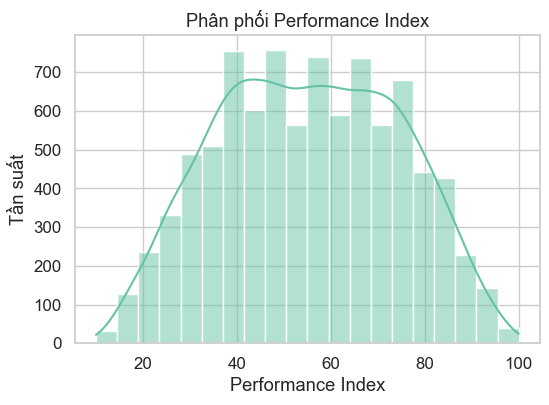

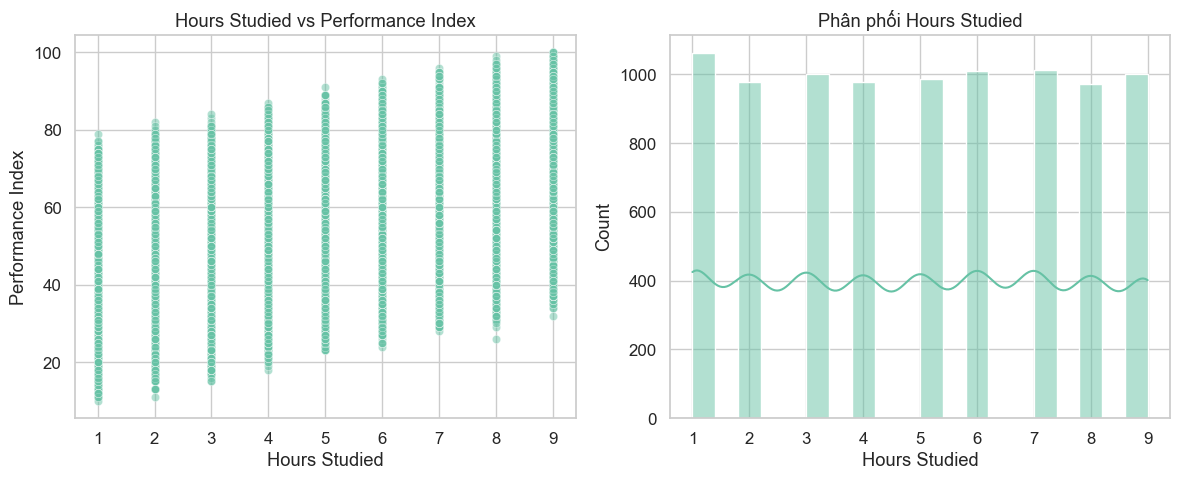

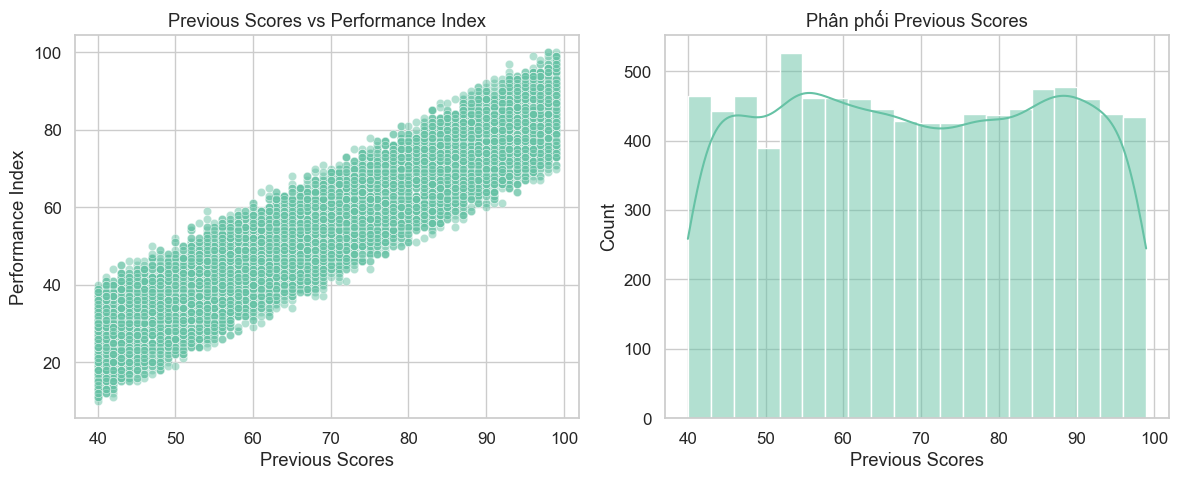

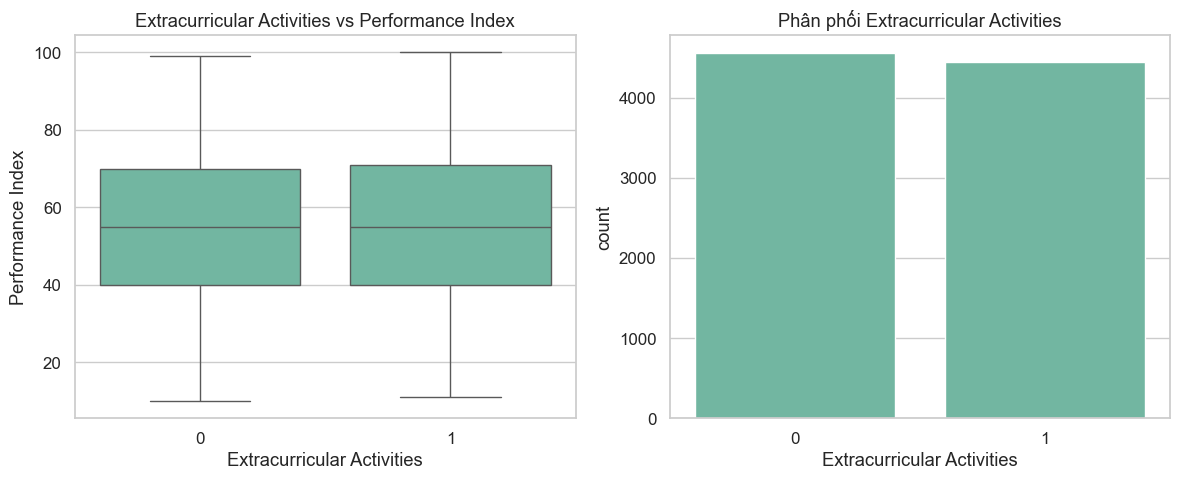

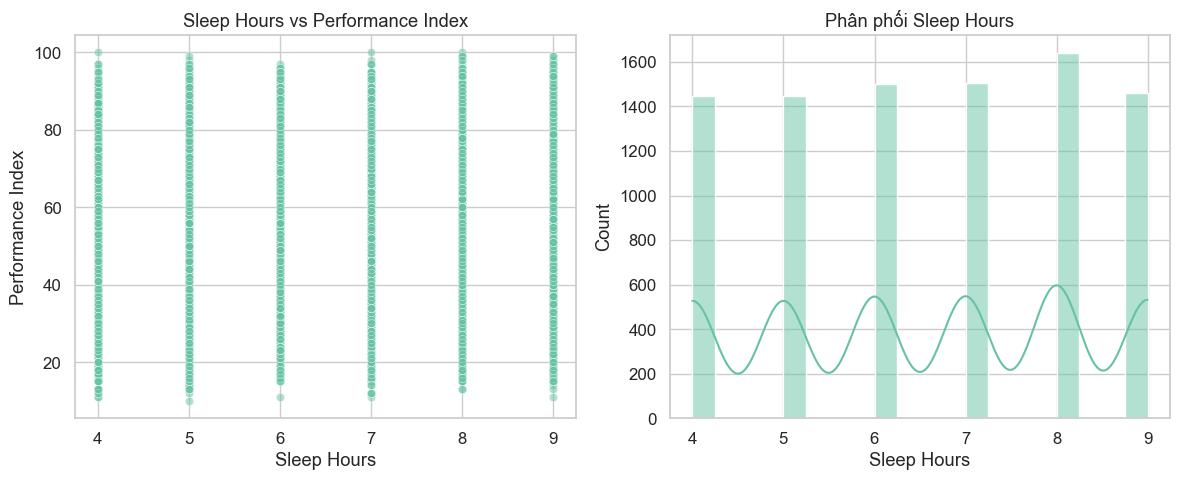

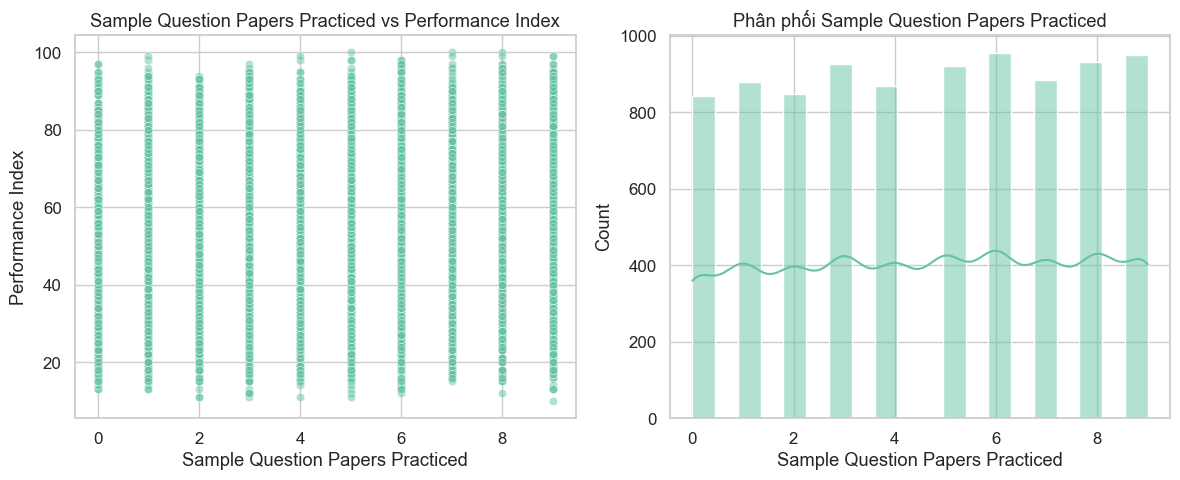

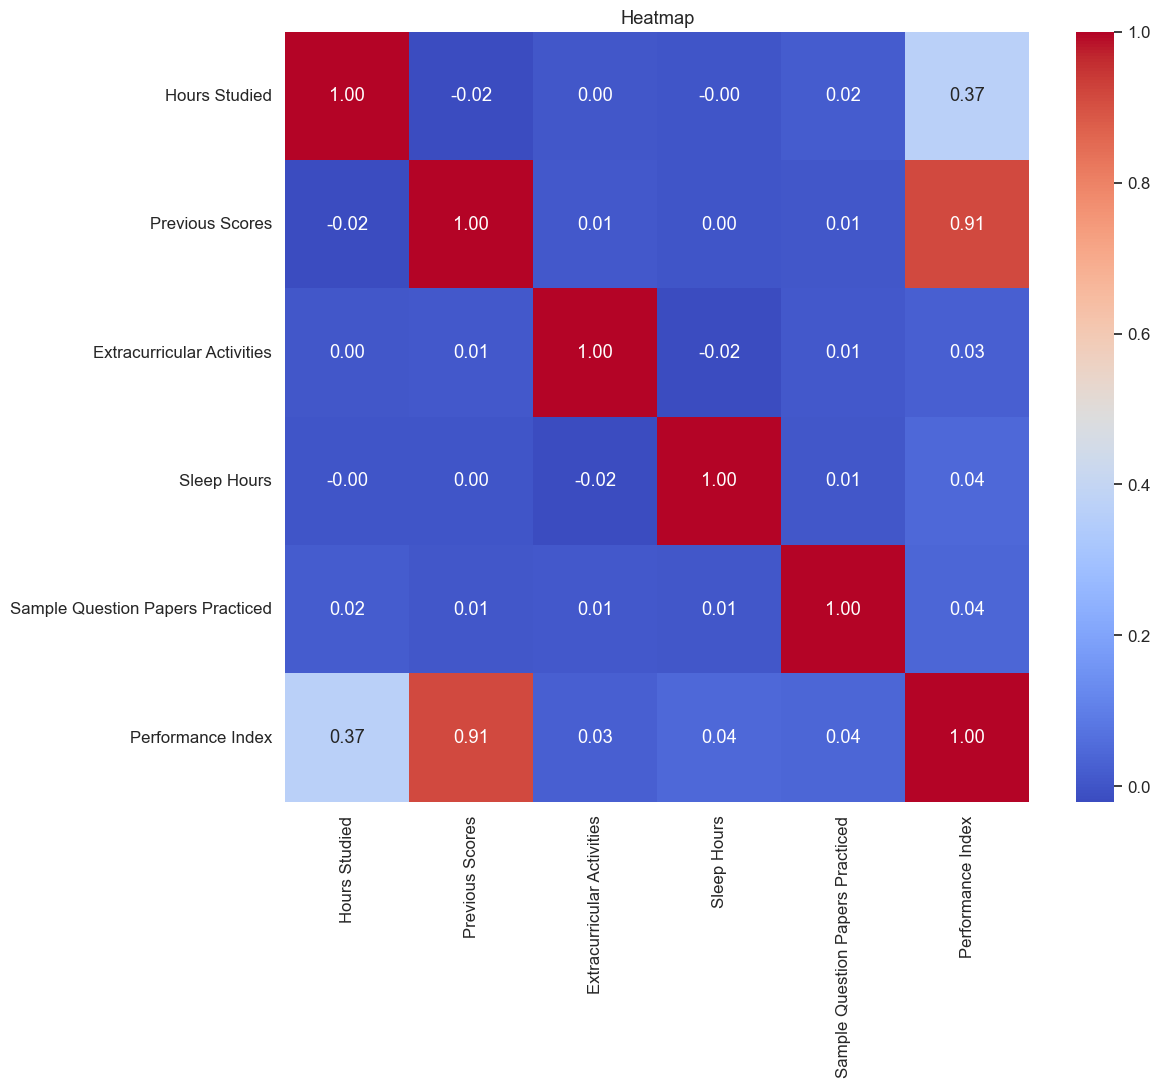

Top features ảnh hưởng mạnh nhất:
Previous Scores                     0.914775
Hours Studied                       0.369148
Sleep Hours                         0.043980
Sample Question Papers Practiced    0.041088
Extracurricular Activities          0.025637
dtype: float64


In [1290]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện

target_col="Performance Index"

show_dataset_info(train)
analyze_target(train, target_col=target_col)
analyze_features(train, target_col=target_col)
show_correlation_matrix(train)
rank_features_by_importance(train, target_col=target_col)


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp

In [1291]:
# Phần code cho yêu cầu 2a
features = [
        'Hours Studied',
        'Previous Scores',
        'Extracurricular Activities',
        'Sleep Hours',
        'Sample Question Papers Practiced'
]
model_2a = train_model(X_train, y_train, preprocess_fn=preprocess, model_cls=OLSLinearRegression)
print_regression_equation(model_2a, features, target_name="Student Performance")

Phương trình hồi quy:
Student Performance = -33.969 + 2.852*Hours Studied + 1.018*Previous Scores + 0.604*Extracurricular Activities + 0.474*Sleep Hours + 0.192*Sample Question Papers Practiced


In [1292]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm 
y_pred_2a = model_2a.predict(preprocess(X_test))

mae = calc_mae(y_test, y_pred_2a)
print(f"MAE trên tập kiểm tra: {mae}")

MAE trên tập kiểm tra: 1.5956486884762935


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852*\text{Hours Studied} + 1.018*\text{Previous Scores} + 0.604*\text{Extracurricular Activities} + 0.474*\text{Sleep Hours} + 0.192*\text{Sample Question Papers Practiced}$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [1293]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu

models_2b_dict = { feat: X_train[[feat]] for feat in features }

folds_2b = kfold_split(X_train.shape[0], k=5, random_state=42)
results_2b = cross_validate_models(X_train, y_train, models_2b_dict, folds=folds_2b)

results_df = format_cv_results(results_2b)
print(results_df)

best_feature = results_df.iloc[0]['Model']
print(f"\nĐặc trưng tốt nhất: {best_feature}")

                              Model        MAE
0                   Previous Scores   6.618215
1                     Hours Studied  15.448599
2                       Sleep Hours  16.187007
3  Sample Question Papers Practiced  16.188386
4        Extracurricular Activities  16.195873

Đặc trưng tốt nhất: Previous Scores


In [1294]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_2b = X_train[[best_feature]]
best_feature_model = train_model(X_2b, y_train, preprocess_fn=preprocess, model_cls=OLSLinearRegression)

print_regression_equation(best_feature_model, [best_feature], target_name="Student Performance")

Phương trình hồi quy:
Student Performance = -14.989 + 1.011*Previous Scores


In [1295]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
X_test_proc = preprocess(X_test[[best_feature]])
y_pred_2b = best_feature_model.predict(X_test_proc)

mae = calc_mae(y_test, y_pred_2b)
print(f"MAE trên tập kiểm tra: {mae}")

MAE trên tập kiểm tra: 6.544277293452506


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011*\text{Previous Scores}$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất

## Xây dựng/Thiết kế mô hình

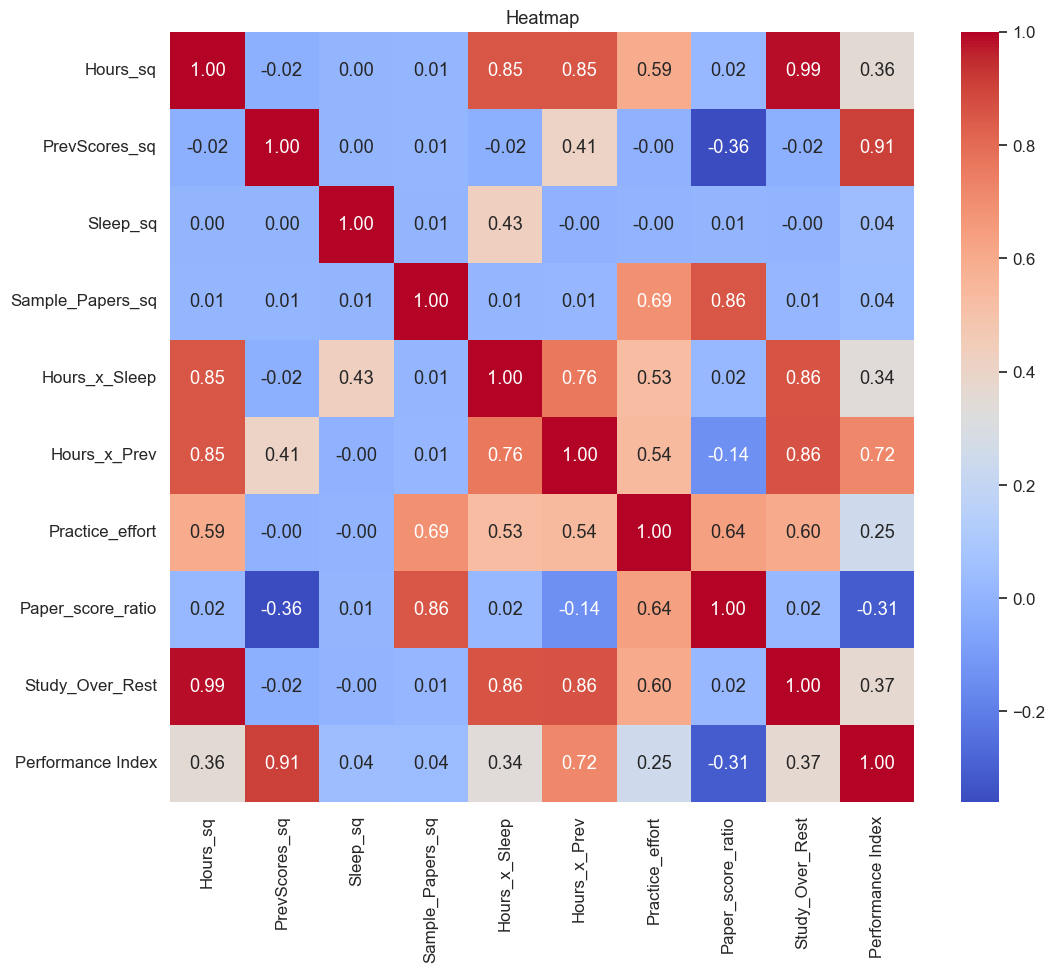

In [1296]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình

features = [
        'Hours Studied',
        'Previous Scores',
        'Extracurricular Activities',
        'Sleep Hours',
        'Sample Question Papers Practiced'
]

def add_features(df):
    df = df.copy()

    # Polynomial features
    df['Hours_sq'] = df['Hours Studied'] ** 2
    df['PrevScores_sq'] = df['Previous Scores'] ** 2
    df['Sleep_sq'] = df['Sleep Hours'] ** 2
    df['Sample_Papers_sq'] = df['Sample Question Papers Practiced'] ** 2

    # Interaction features
    df['Hours_x_Sleep'] = df['Hours Studied'] * df['Sleep Hours']
    df['Hours_x_Prev'] = df['Hours Studied'] * df['Previous Scores']

    # Custom features
    df['Practice_effort'] = df['Sample Question Papers Practiced'] * df['Hours Studied']
    df['Paper_score_ratio'] = df['Sample Question Papers Practiced'] / (df['Previous Scores'] + 1e-6)
    df['Study_Over_Rest'] = df['Hours Studied'] / (24 - df['Hours Studied'] - 2*df['Extracurricular Activities'] + 1e-6)

    return df

target_col = 'Performance Index'

X_train_2c = add_features(train)

new_features = [col for col in X_train_2c.columns if col not in features + [target_col]]

# Hiển thị correlation matrix chỉ với các cột mới
show_correlation_matrix(X_train_2c[new_features + ['Performance Index']])

X_test_2c = add_features(test)

# Định nghĩa các mô hình 2c
models_dict = {
    "Model 1: Top 3 Most Influential Features":
        X_train_2c[['Hours Studied', 'Sleep Hours', 'Previous Scores']],
    "Model 2: Top 2 Most Influential Features + Squared Terms":
        X_train_2c[['Hours Studied', 'Previous Scores', 'Hours_sq', 'PrevScores_sq']],
    "Model 3: Interaction-Based Features":
        X_train_2c[['Paper_score_ratio', 'Practice_effort', 'Study_Over_Rest','Hours_x_Prev']],
    "Model 4: Combined Polynomial + Interaction":
        X_train_2c[features + ['Hours_sq', 'PrevScores_sq', 'Hours_x_Sleep', 'Hours_x_Prev']]
}

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [1297]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu

# Chạy cross-validation
folds_2c = kfold_split(X_train_2c.shape[0], k=5, random_state=42)
cv_results = cross_validate_models(X_train_2c, y_train, models_dict, folds=folds_2c)
cv_results_df = format_cv_results(cv_results)
print("\nCross-validation MAE cho từng mô hình:")
print(cv_results_df)

# Tìm mô hình tốt nhất
best_model_name = cv_results_df.iloc[0]['Model']
print(f"\nMô hình tốt nhất: {best_model_name}")



Cross-validation MAE cho từng mô hình:
                                               Model       MAE
0         Model 4: Combined Polynomial + Interaction  1.621631
1           Model 1: Top 3 Most Influential Features  1.702118
2  Model 2: Top 2 Most Influential Features + Squ...  1.815747
3                Model 3: Interaction-Based Features  6.809077

Mô hình tốt nhất: Model 4: Combined Polynomial + Interaction


In [1298]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện

X_train_best = X_train_2c[models_dict[best_model_name].columns]
my_best_model = train_model(X_train_best, y_train)
print_regression_equation(my_best_model, models_dict[best_model_name].columns.tolist(), target_name="Student Performance", decimals=4)

Phương trình hồi quy:
Student Performance = -34.0972 + 2.7868*Hours Studied + 1.0288*Previous Scores + 0.6051*Extracurricular Activities + 0.4437*Sleep Hours + 0.1925*Sample Question Papers Practiced + 0.004*Hours_sq - 0.0001*PrevScores_sq + 0.006*Hours_x_Sleep - 0.0002*Hours_x_Prev


In [1299]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
X_test_best = preprocess(X_test_2c[models_dict[best_model_name].columns])
y_pred_2c = my_best_model.predict(X_test_best)
mae = calc_mae(y_test, y_pred_2c)

print(f"\nMAE trên tập test: {mae:.5f}")


MAE trên tập test: 1.59373


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012
$$
\text{Student Performance} = -34.097
+ 2.787*\text{Hours Studied}
+ 1.029*\text{Previous Scores}\\
+ 0.605*\text{Extracurricular Activities}
+ 0.444*\text{Sleep Hours}
+ 0.193*\text{Sample Question Papers Practiced}\\
+ 0.004*\text{Hours\_sq}
- 0.0001*\text{PrevScores\_sq}
+ 0.006*\text{Hours\_x\_Sleep}
- 0.0002*\text{Hours\_x\_Prev}
$$
